# Forecasting
Prediction of sales is the central task in this challenge. you want to predict daily sales in various stores up to 6 weeks ahead of time. This will help the company plan ahead of time. 

The following steps outline the various sub tasks needed to effectively do this: 

In [5]:
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.7 kB/s eta 0:00:00m eta 0:00:010:00:02m


In [1]:
# importing of libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_score
import seaborn as sns
import os,sys
from lightgbm import LGBMRegressor
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from timeseries import TimeSeries
from modeling import Modeler
sns.set()


2022-05-28 22:21:50.995396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-28 22:21:50.995438: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/home/martin/Documents/pharm_sales/notebooks
The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


2.2 Building models with sklearn pipelines
At this point, all our features are numeric. Since our problem is a regression problem, you can narrow down the list of algorithms you can use for modelling. 

A reasonable starting point will be to use any of the tree based algorithms. Random forests Regressor will make for a good start. 

Also, for the sake of this challenge, work with sklearn pipelines. This makes modeling modular and more reproducible. Working with pipelines will also significantly reduce your workload when you are moving your setup into files for the next part of the challenge. Extra marks will be awarded for doing this.


In [2]:
train_ = pd.read_csv("../data/cleaned_train.csv")
test = pd.read_csv("../data/cleaned_test.csv")
train=train_.loc[:,train_.columns!='Sales']
train['Sales']=train_['Sales']
train.set_index('Date',inplace=True)

In [6]:
train.index

RangeIndex(start=0, stop=324275, step=1)

In [4]:
inputs = train[:1]

# Modeling with RandomForest

In [4]:
analyzer = Modeler(train)

In [12]:
forecast = analyzer.regr_models(model_=RandomForestRegressor,column='Sales',inputs=inputs,
                                connect=True,n_estimators=10)

/home/martin/Documents/pharm_sales/env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [13]:
scores,forecast = forecast

In [14]:
scores

0.006357809049529761

In [7]:
forecast = analyzer.regr_models(model_=LGBMRegressor,column='Sales',
                                connect=False,serialize=False,n_estimators=10)

2022/05/28 22:14:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022-05-28 22:14:54,929:scripts.logger:fitted a LGBMRegressor(n_estimators=10) model
2022-05-28 22:14:54,974:scripts.logger:predicting for a group instance


In [8]:
scores,forecast = forecast
scores

1199.9361030914247

From the random forest regressor we notice that we have a mean absolute error of 0.00636, this is not a bad standard but we can try other models to see there performance and how well this works.

# Loss function

Loss functions indicate how well our model is performing. This means that the loss functions affect the overall output of sales prediction.
Different loss functions have different use cases.

In this challenge, you’re allowed to choose your own loss function. you need to defend the loss function you choose for this challenge. Feel free to be creative with your choice. You might want to use loss functions that are easily interpretable.

In [2]:
abs(analyzer.log_loss(model = RandomForestRegressor,column='Sales',custom=True))

0.458

In [3]:
abs(analyzer.log_loss(model = LGBMRegressor,column='Sales',custom=True))

0.543

So using the log loss function we know that the closer you are to zero the better your log loss function and therefore for this challenge the best log loss is for the RandomForest Regressor because it was the one with the closest value to zeror of 0.458

# Feature Importance 
Explore the feature importance from our modelling. Creatively deduce a way to estimate the confidence interval of your predictions. Extra marks will be given for this

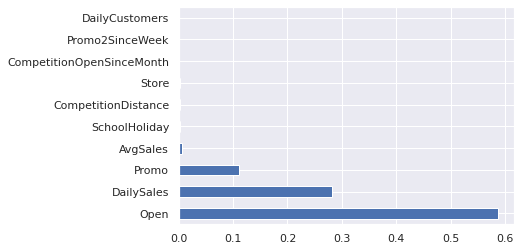

Assortment                   0.000444
AvgCustomers                 0.001173
AvgSales                     0.006662
CompetitionDistance          0.001599
CompetitionOpenSinceMonth    0.001349
CompetitionOpenSinceYear     0.000906
DailyCustomers               0.001186
DailySales                   0.282274
Open                         0.586433
Promo                        0.111027
Promo2                       0.000000
Promo2SinceWeek              0.001232
Promo2SinceYear              0.000871
PromoInterval                0.000316
SchoolHoliday                0.001995
StateHoliday                 0.000166
Store                        0.001556
StoreType                    0.000811
dtype: float64

In [5]:
analyzer.feature_importance(model_=RandomForestRegressor,column='Sales')

For feature importance we notice that the Open variable is the most important feature with a probability of 0.586, and then it is followed by DailySales with a 0.2822 and then promo with a 0.111, we also notice that there are some variables that do not have any effect like promo2 and in our second run we shall remove it and see how our results shall behave, if it is good then we shall realize the issue is with our function

# Serialization

To serve the models you built above, you need to serialize them. Save the model with the timestamp(eg. 10-08-2020-16-32-31-00.pkl). This is necessary so that you can track predictions from various models.

Assume that you’ll make daily predictions. This means you’ll have various models for predictions hence the reason for serializing the models in the format above.

In [4]:
forecast = analyzer.regr_models(model_=RandomForestRegressor,column='Sales',
                                connect=False,serialize=True,n_estimators=10)

2022-05-25 11:36:07,382:logger:Successfully saved the model


Serializing or saving the data, is done in the function regr_models, and it is good that we do this because also in the case of an api, this shall come in really handy